clk=timestamp+19

traces start at clk 1

In [1]:
from tes.data import Data,PacketStream,Packet,PayloadType,EventFlags,Event
import numpy as np
import matplotlib.pyplot as plt

In [2]:
trace_dt=np.dtype([('raw','i4'),('filtered','i4'),('slope','i4'),('filteredL','i4')])
stream_dt=np.dtype([('data','i4'),('last','i4')])
minmax_dt=np.dtype([('filtered','i4'),('low_threshold','i4'),('high_threshold','i4'),('clk','i4')])
cfd_dt=np.dtype('i4')
filteredxing_dt=np.dtype([('extrema','i4'),('area','i4'),('clk','i4')])

In [57]:
traces=np.fromfile('data/traces',trace_dt)
stream=np.fromfile('data/bytestream',stream_dt)
minmax=np.fromfile('data/minmax',minmax_dt)
cfd=np.fromfile('data/cfd',cfd_dt)
filteredxing=np.fromfile('data/filteredxing',filteredxing_dt)

In [3]:
traces=Data.fromfile('traces',trace_dt,'teslib','measurement_subsystem_TB',tool='vivado')
stream=Data.fromfile('bytestream',stream_dt,'teslib','measurement_subsystem_TB',tool='vivado')
minmax=Data.fromfile('minmax',minmax_dt,'teslib','measurement_subsystem_TB',tool='vivado')
cfd=Data.fromfile('cfd',cfd_dt,'teslib','measurement_subsystem_TB',tool='vivado')
filteredxing=Data.fromfile('filteredxing',cfd_dt,'teslib','measurement_subsystem_TB',tool='vivado')

<IPython.core.display.Javascript object>


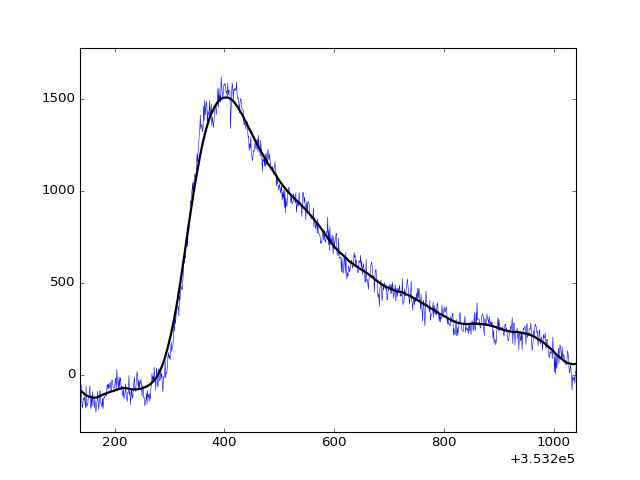

In [8]:
%matplotlib notebook
plt.plot(traces['raw'][1100:],linewidth=0.5)
plt.plot(traces['filtered'][1100:],'k',linewidth=2)

In [59]:
bs=PacketStream(stream)
bs.packets

[ethertype:88B5 length:48 Payload:tick frame:0 protocol:0,
 ethertype:88B5 length:48 Payload:tick frame:1 protocol:1,
 ethertype:88B5 length:32 Payload:peak frame:2 protocol:2,
 ethertype:88B5 length:56 Payload:pulse frame:3 protocol:3,
 ethertype:88B6 length:1496 Payload:MCA frame:4 protocol:0,
 ethertype:88B6 length:1496 Payload:MCA frame:5 protocol:1,
 ethertype:88B6 length:1496 Payload:MCA frame:6 protocol:2,
 ethertype:88B6 length:1496 Payload:MCA frame:7 protocol:3,
 ethertype:88B6 length:1496 Payload:MCA frame:8 protocol:4,
 ethertype:88B6 length:1496 Payload:MCA frame:9 protocol:5,
 ethertype:88B6 length:1496 Payload:MCA frame:10 protocol:6,
 ethertype:88B6 length:1496 Payload:MCA frame:11 protocol:7,
 ethertype:88B6 length:1496 Payload:MCA frame:12 protocol:8,
 ethertype:88B6 length:1496 Payload:MCA frame:13 protocol:9,
 ethertype:88B6 length:1496 Payload:MCA frame:14 protocol:10,
 ethertype:88B6 length:1496 Payload:MCA frame:15 protocol:11,
 ethertype:88B6 length:1496 Payload

In [60]:
es=bs.eventstream

In [61]:
def plot_event(event_tupple):
    pre=200
    post=1000
    timestamp=event_tupple[0]
    event_type=event_tupple[1]
    event=event_tupple[2]
    flags=EventFlags(event['flags'])
    print(flags)
    print('timestamp',timestamp, 'time', event['time'])
    if flags.type == Event.tick:
        return
    s=traces['filtered'][timestamp+18-pre:timestamp+18+post]
    r=traces['raw'][timestamp+18-pre:timestamp+18+post]
    i = np.where(abs(minmax['clk'])<=timestamp+19)[0][-1]
    min_t=abs(minmax['clk'][i])-timestamp-18
    plt.plot(r,'--k')
    plt.plot(s)
    plt.plot([pre],s[pre],'sg')
    plt.plot([pre+min_t],minmax['filtered'][i],'ob')
    if event_type==Event.pulse:
        for i in range(flags.peak_number):
            p=event['peaks'][i]
            plt.plot([0,len(s)-1],[p['height'],p['height']],':r')
    else:
      plt.plot([0,len(s)-1],[event['height'],event['height']],':r')
        
    #print(event['height'],event['minima'])
    #print(minmax['filtered'][i]==s[pre+min_t])
    #print(minmax['filtered'][i]==event['minima'])
    #print(s[pre],s[pre-1])

Event:peak channel:0 peak_number:0 cfd_rel2min:True
height:cfd_high timing:cfd_low new window:True
timestamp 74706 time 1170


<IPython.core.display.Javascript object>


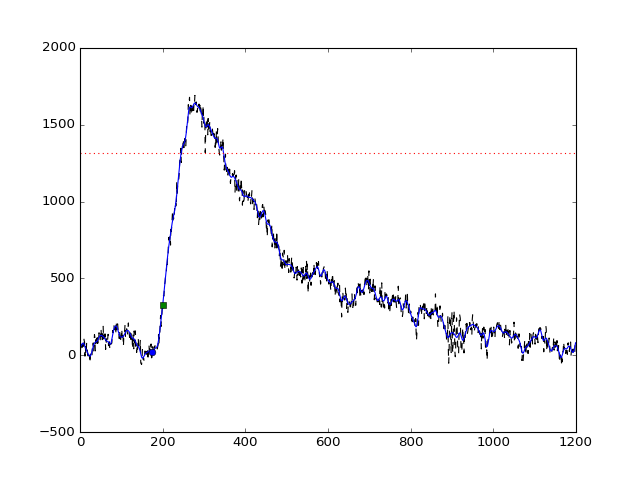

In [63]:
%matplotlib notebook
plot_event(es[7])

In [64]:
bs.distributions

[Distribution: channel:0 value:filtered_signal, trigger:clock, qualifier:all,
 Distribution: channel:0 value:filtered_signal, trigger:clock, qualifier:all,
 Distribution: channel:0 value:filtered_signal, trigger:clock, qualifier:all]

In [65]:
d=bs.distributions[0]
eset=np.uint64(1)
bset=np.uint64(0)
cset=np.uint64(20)

stop=d.stop_time+eset+cset
start=d.start_time+bset+cset
bins=np.zeros((d.last_bin+1,),dtype=np.uint32)
for i in range(start,stop):
    s = traces['filtered'][i]
    if s <= d.lowest_value:
        bins[0] += 1
    else:
        bins[s-d.lowest_value] += 1
        
(bins-d.counts).nonzero()

(array([], dtype=int64),)

In [42]:
d.overflow

0

In [55]:
sum(bins)

18384

In [56]:
sum(d.counts)

18384

In [ ]:
2**14+2000

In [ ]:
es[3][2]['timestamp']-es[0][2]['timestamp']

In [ ]:
def xings(s, thresh):
    pos=s > thresh
    neg=s < thresh
    pos0=s >= thresh
    neg0=s <= thresh
    pos_xing_mask = np.bitwise_and(pos0[1:],neg[0:-1])  
    neg_xing_mask = np.bitwise_and(neg0[1:],pos[0:-1])  
    return pos_xing_mask.nonzero()[0]+1, neg_xing_mask.nonzero()[0]+1

In [ ]:
from mpl_toolkits.axes_grid1 import host_subplot

def plot_trace(traces,start,width):

    ax = host_subplot(111)
    axr = ax.twinx()
    axt = ax.twiny()
#ax.plot(t[0:-1:10],s[0:-1:10],'k')
#ax.plot(t,s,'k')
    axt.set_xlabel('Time ns',fontsize=18)
    ax.set_ylabel('Voltage (Arbitary Units)',fontsize=18)
#plt.xticks(visible=False)
#plt.yticks(visible=False)
#ax.set_xlim(0,t[4000000])
#start=902000
#width=2500
    f=traces['filtered'][start:start+width]
    s=traces['slope'][start:start+width]
    t=np.arange(len(f))*4e-9
#ts=t[pstart:pstop]
#axins = fig.add_axes([.4, .45, .45, .4])
    ax.set_xlim(t[0],t[-1])
    axt.set_xlim(t[0],t[-1])

    ylim=(-500,2000)

    ax.set_ylim(ylim[0],ylim[1])
    axr.set_ylim(ylim[0],ylim[1])

    filtered, = ax.step(t,f,'k',lw=2,label='filtered')
    slope, = ax.step(t,s,'b',label='slope')
    ax.fill_between(t,0,s,alpha=.4)
    plt.ylim=ylim

pos=s>0
neg=s<=0
pos_xing_mask = np.bitwise_and(pos[1:-1],neg[0:-2])  
neg_xing_mask = np.bitwise_and(neg[1:-1],pos[0:-2])  
pos_xing=pos_xing_mask.nonzero()
neg_xing=neg_xing_mask.nonzero()

rx=[t[pos_xing[0][0]], t[neg_xing[0][0]]]
ry=[f[pos_xing[0][0]], f[neg_xing[0][0]]]

ax.fill_between(t[pos_xing[0][0]:neg_xing[0][0]],0,s[pos_xing[0][0]:neg_xing[0][0]],alpha=.4,color='r')

#plt.plot(rx,[ry[0], ry[0]],'-r',lw=2)
#plt.plot([rx[1],rx[1]], ry,'-r',lw=2)
# thresholds
sthresh = 600
pthresh = 1000
plt.plot([t[0], t[-1]], [sthresh, sthresh], '--b', lw=2)
plt.plot([t[0], t[-1]], [pthresh, pthresh], '--k', lw=2)

sthresh_xing=(s>sthresh).nonzero()[0][0]
pthresh_xing=(f>pthresh).nonzero()[0][0]


cf=.10
height = ry[1]-ry[0]
cfl=ry[0]+(height*cf)
cfh=ry[1]-(height*cf)

cfl_xing=(f>cfl).nonzero()[0][0]
cfd_low=f[cfl_xing]
cfh_xing=(f>cfh).nonzero()[0][0]
cfd_high=f[cfh_xing]

#plt.plot([t[cfl_xing], t[-1]],[cfd_low, cfd_low], ':r')
#plt.plot([t[cfh_xing], t[-1]],[cfd_high, cfd_high], ':r')
#plt.plot([x[1], t[-1]],[y[1], y[1]], ':r')
plt.legend([filtered, slope],['Signal', 'Slope'],loc=2)

#axr = ax.twinx()
##################################################################
#yticks=([ry[0],sthresh,pthresh,cfd_high,ry[1]])
yticks=([sthresh,pthresh])
axr.set_yticks(yticks)
#yticklabels=['Start','Slope threshold','Pulse threshold','CF high','Peak']
yticklabels=['Slope threshold','Pulse threshold']
axr.set_yticklabels(yticklabels, color='r',fontsize=14)
axr.get_yticklabels()[0].set_color('b')
axr.get_yticklabels()[1].set_color('k')

#xticks=([rx[0],t[cfl_xing],t[sthresh_xing],t[pthresh_xing],rx[1]])
xticks=(t[cfl_xing],rx[1])
#ax.set_xticks([rx[0],t[cfl_xing],t[sthresh_xing],t[pthresh_xing],rx[1]])
ax.set_xticks(xticks)
#xticklabels=['Start','CF low','Slope xing','Signal xing','Peak']
xticklabels=['CF low','Peak']
ax.set_xticklabels(xticklabels, color='r',fontsize=14)

#plt.plot([t[cfh_xing], t[-1]],[cfd_high, cfd_high], ':r')
#horoz start, stop lines
#hpeak=ax.plot([xticks[1], t[-1]],[yticks[-1], yticks[-1]], '-.r')
#hstart=ax.plot([xticks[0], t[-1]],[yticks[0], yticks[0]], '-.r')
#vert start stop
vstart=ax.plot([xticks[0], xticks[0]],[cfd_low, ylim[0]], '-.r')
vpeak=ax.plot([xticks[1], xticks[1]],[ylim[0], ry[1]], '-.r')

plt.tight_layout()
plt.savefig('..//peakextraction7.svg')
plt.show()
print('risetime:',(xticks[1]-xticks[0])/4)
print('height:',yticks[-1]-yticks[0])
print('time:',(xticks[0]-rx[0])/4)
print('area',sum(s[pos_xing[0][0]:neg_xing[0][0]])/256)


In [ ]:
slope_0xings = xings(traces['slope'],0)

In [ ]:
slope_0xings

In [ ]:
%matplotlib notebook
start=10000
width=300
plt.plot(traces['filtered'][start:start+width]/2)

In [ ]:
%matplotlib notebook
plt.plot(traces['slope'][20400:21700])

In [ ]:
filtered=traces['filtered'][1100:]
filteredL=traces['filteredL'][1100:]

In [ ]:
filtered[:10]

In [ ]:
filteredL[:10]/4

In [ ]:
minmax_dt=np.dtype([('filtered','i4'),('low','i4'),('high','i4'),('clk','i4')])
minmax=Data.fromfile('minmax',minmax_dt,'teslib','measurement_subsystem_TB',tool='vivado')
fxing_dt=np.dtype([('extrema','i4'),('area','i4'),('clk','i4')])
fxing=Data.fromfile('filteredxing',fxing_dt,'teslib','measurement_subsystem_TB',tool='vivado')

In [ ]:
minmax

In [ ]:
fxing

In [ ]:
np.where(fxing['area']==0)

In [ ]:
np.where(fxing['extrema']==0)

In [ ]:
fxing[30]

In [ ]:
exn=np.where(fxing['extrema']<0)
clkn=np.where(fxing['clk']>0)

In [ ]:
fxing[374]

In [ ]:
clkn

In [ ]:
np.where(minmax[maxs[0]-1]['min']!=1)

In [ ]:
minmax[maxs[0]-1][65]

In [ ]:
2290-925

In [ ]:
0.375*4

In [ ]:
np.where(minmax['clock']==2290)

In [ ]:
minmax[120:140]

In [ ]:
stream_dt=np.dtype([('data','>i4'),('last','i4')])
#stream=np.fromfile('data/stream',stream_dt)

### bytestream stuff

In [ ]:
stream_dt=np.dtype([('data','i4'),('last','i4')])
stream=Data.fromfile('bytestream',stream_dt,'teslib','measurement_subsystem_TB',tool='vivado')
lasts=np.where(stream['last']<=0)[0]+1
#data=np.copy(stream['data'])

In [ ]:
stream

In [ ]:
stream=np.fromfile('data/bytestream',stream_dt)

In [ ]:
bs=PacketStream(stream)

In [ ]:
bs.packets

In [ ]:
bs.packets[4]

In [ ]:
eheader_dt=[('etype','<u2'),('length','u2'),()]

In [ ]:
'{:X}'.format(bs.packets[1].bytes[23])


In [ ]:
'{:X}'.format(bs.packets[0].bytes[28:30].view(np.uint16)[0])

In [ ]:
pulse_peak_dt=np.dtype([('height','i2'),('rise','i2'),('minima','u2'),('time','i2')])
pulse_dt=np.dtype([('size','i2'),('resv','i2'),('flags','i2'),('time','u2'),
                  ('area','i4'),('length','i2'),('offset','i2'),('peaks',(pulse_peak_dt,2))])

In [ ]:
pulses=bs.packets[3].payload.view(pulse_dt)

In [ ]:
pulses['peaks']

In [ ]:
pulses['offset']

In [ ]:
pulses['length']

In [ ]:
class eflags:
    def __init__(self,uint16):
        self.new_window=np.bitwise_and(uint16,0x00000001)!=0
        self.tick=np.bitwise_and(uint16,0x00000002)!=0
        self.type=np.right_shift(np.bitwise_and(uint16,0x0000000c),2)
        
    def __repr__(self):
        return 'New window:{:}\n'.format(self.new_window) + \
               'Tick:{:}\n'.format(self.tick) + \
               'Type:{:}\n'.format(self.type) 

In [ ]:
f=eflags(pulses[0]['flags'])
f

In [ ]:
'{:X}'.format(bs.packets[3].bytes[13:14].view(np.uint16))

In [ ]:
'{:X}'.format(bs.packets[3].bytes[14:16].view(np.uint16)[0])

In [ ]:
bs.packets[3].bytes[14:16].view(np.uint16)[0]

In [ ]:
bs=np.uint8(stream['data'][:48])

In [ ]:
bs

In [ ]:
events=stream['data'].view(event_dt)

In [ ]:
'{:X}'.format(events['flags'][0])

In [ ]:
events['rise']

In [ ]:
events

In [ ]:
'{:04X}'.format(events['flags'][1])

In [ ]:
pulse_peak_dt=np.dtype([('time','>i2'),('minima','>i2'),('rise','>u2'),('height','>i2')])
pulse_dt=np.dtype([('time','>i2'),('flags','>i2'),('resv','>i2'),('size','>u2'),
                  ('offset','>i2'),('length','>i2'),('area','>i4'),('peaks',(pulse_peak_dt,1))])
data=np.copy(stream['data'])

In [ ]:
pulses=data.view(pulse_dt)

In [ ]:
pulses['peaks']['height']-pulses['peaks']['minima']

In [ ]:
pulses['peaks']['minima']

In [ ]:
peak_count=np.right_shift(np.bitwise_and(pulses['flags'],0xF000),12)
peak_overflow=np.bitwise_and(pulses['flags'],0x0800)!=0
channel=np.right_shift(np.bitwise_and(pulses['flags'],0x0700),8)
timing_type=np.right_shift(np.bitwise_and(pulses['flags'],0x00C0),6)
height_type=np.right_shift(np.bitwise_and(pulses['flags'],0x0030),4)
event_type=np.right_shift(np.bitwise_and(pulses['flags'],0x000E),1)
new_window=np.bitwise_and(pulses['flags'],0x0001)!=0

In [ ]:
peak_overflow

In [ ]:
test_dt=np.dtype(
    [('time','i2'),('flags','i2'),('rise','u2'),('minima','i2'),('low','u8'),('high','u8')]
)
test=data.view(test_dt)

In [ ]:
test

In [ ]:
test['minima']

In [ ]:
low1=np.int32(np.right_shift(np.bitwise_and(test['low'],0x03FFFF000000000),36))
s=(np.bitwise_and(low1,0x00020000)!=0)*0xFFFC0000
low2=np.int32(np.right_shift(np.bitwise_and(test['low'],0x000000FFFFC0000),18))
low_threshold=np.int32(np.bitwise_and(test['low'],0x00000000003FFFF))
high1=np.int32(np.right_shift(np.bitwise_and(test['high'],0x03FFFF000000000),36))
high2=np.int32(np.right_shift(np.bitwise_and(test['high'],0x000000FFFFC0000),18))
high_threshold=np.int32(np.bitwise_and(test['high'],0x00000000003FFFF))

In [ ]:
np.int32(np.bitwise_or(low1,s))/8.0

In [ ]:
'{:04X}'.format(low1[0])

In [ ]:
high1/8.0

In [ ]:
high2/8.0

In [ ]:
'{:04X}'.format(high_threshold[0])

In [ ]:
from enum import Enum

In [ ]:
class VhdlEnum(int, Enum):

    def __str__(self):
        return self.name.replace("-", " ")
    
    def select(self):
        return pow(2, self.value)
    

In [ ]:
class Test(VhdlEnum):
    a=0
    b=1

In [ ]:
Test(0)